This is our best scoring model, which got 0.87709 in public scoring

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pre-activation basic block with optional dropout
class PreActBlock(nn.Module):
    expansion = 1  # Defines the expansion factor for residual connections (not used here)

    def __init__(self, in_planes, out_planes, stride=1, drop_prob=0.0):
        super().__init__()
        # First batch normalization before convolution
        self.bn1 = nn.BatchNorm2d(in_planes)
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        # Second batch normalization before second convolution
        self.bn2 = nn.BatchNorm2d(out_planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.drop_prob = drop_prob  # Dropout probability

        # Shortcut connection for residual learning
        if stride != 1 or in_planes != out_planes:
            # If dimensions change, apply convolution to adjust shortcut
            self.shortcut = nn.Conv2d(in_planes, out_planes, kernel_size=1,
                                      stride=stride, bias=False)
        else:
            # Otherwise, identity shortcut
            self.shortcut = nn.Identity()

    def forward(self, x):
        # First pre-activation with ReLU
        out = F.relu(self.bn1(x))
        # Adjust shortcut path if needed
        shortcut = self.shortcut(out) if not isinstance(self.shortcut, nn.Identity) else x
        # First convolution
        out = self.conv1(out)
        # Second pre-activation with ReLU
        out = F.relu(self.bn2(out))
        # Apply dropout if specified
        if self.drop_prob > 0:
            out = F.dropout(out, p=self.drop_prob, training=self.training)
        # Second convolution
        out = self.conv2(out)
        # Add shortcut for residual learning
        out += shortcut
        return out

# RobustResNet64-like model for CIFAR-like images.
# Total layers: 1 conv + 3 groups * (2 convs per block * 10 blocks) + final FC = 1 + 60 + 1 = 62 layers.
class RobustResNet64(nn.Module):
    def __init__(self, num_blocks=10, base_channels=32, num_classes=10, drop_prob=0.1):
        super().__init__()
        self.in_planes = base_channels
        # Initial convolution for feature extraction
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)

        # Three groups of residual blocks
        self.layer1 = self._make_layer(base_channels, num_blocks, stride=1, drop_prob=drop_prob)
        self.layer2 = self._make_layer(base_channels * 2, num_blocks, stride=2, drop_prob=drop_prob)
        self.layer3 = self._make_layer(base_channels * 4, num_blocks, stride=2, drop_prob=drop_prob)

        # Final batch normalization before fully connected layer
        self.bn = nn.BatchNorm2d(base_channels * 4)
        self.linear = nn.Linear(base_channels * 4, num_classes)

        # Weight initialization following best practices
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # Helper function to create multiple residual blocks in each layer
    def _make_layer(self, out_planes, blocks, stride, drop_prob):
        layers = []
        # First block may include downsampling
        layers.append(PreActBlock(self.in_planes, out_planes, stride=stride, drop_prob=drop_prob))
        self.in_planes = out_planes
        # Remaining blocks retain the same dimensions
        for _ in range(1, blocks):
            layers.append(PreActBlock(self.in_planes, out_planes, stride=1, drop_prob=drop_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # Final batch normalization and ReLU
        out = F.relu(self.bn(out))
        # Global average pooling before final fully connected layer
        out = F.adaptive_avg_pool2d(out, 1).view(out.size(0), -1)
        out = self.linear(out)
        return out

if __name__ == "__main__":
    # Create an instance of the model
    model = RobustResNet64(num_blocks=10, base_channels=32, num_classes=10, drop_prob=0.1)
    # Dummy input for testing (e.g., CIFAR images with size 32x32)
    x = torch.randn(2, 3, 32, 32)
    y = model(x)
    print("Output shape:", y.shape)
    # Display total trainable parameters in the model
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,} (~{total_params/1e6:.2f}M)")

Output shape: torch.Size([2, 10])
Total trainable parameters: 3,799,978 (~3.80M)


In [ ]:
# train.py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import pickle
from torch.utils.data import DataLoader, Dataset
from PIL import Image
#from model import LightResNet18
from tqdm import tqdm

# Custom collate function for MixUp and CutMix augmentations
def rand_bbox(size, lam):
    # Calculate the bounding box size based on lambda
    W = size[3]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly pick the center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # Ensure bounding box is within the image bounds
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

# MixUp data augmentation: linearly interpolates between two examples
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# CutMix data augmentation: replaces a portion of one image with a portion from another
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    # Swap portions of images
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

# Collate function for MixUp and CutMix augmentations, decides which to apply per batch
def mixup_cutmix_collate(batch, alpha=1.0, p=0.5):
    # Standard collate function
    images, labels = list(zip(*batch))
    images = torch.stack(images, 0)
    labels = torch.tensor(labels, dtype=torch.long)

    # Decide whether to apply MixUp or CutMix based on a probability
    if np.random.rand() < p:
        # Apply MixUp
        mixed_x, y_a, y_b, lam = mixup_data(images, labels, alpha)
        return mixed_x, (y_a, y_b, lam, 'mixup')
    else:
        # Apply CutMix
        cutmix_x, y_a, y_b, lam = cutmix_data(images, labels, alpha)
        return cutmix_x, (y_a, y_b, lam, 'cutmix')

# Helper function to load data from a pickle file
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

# Custom Dataset class for CIFAR-10
class CIFARDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data.reshape(-1, 3, 32, 32).astype("float32") / 255.0
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]*255
        img = img.astype("uint8")
        # Convert image to PIL format
        img = Image.fromarray(img.transpose(1,2,0))
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Helper function to load CIFAR-10 batches
def load_cifar10_batches(root_dir):
    data_list, labels_list = [], []
    for i in range(1, 6):
        batch_file = f"{root_dir}/data_batch_{i}"
        batch = unpickle(batch_file)
        data_list.append(batch[b'data'])
        labels_list.extend(batch[b'labels'])
    X = np.concatenate(data_list, axis=0)
    y = np.array(labels_list)
    return X, y

# Training function
def train():
    # Check if GPU is available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # 2) Define transformations (data augmentation)
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(),  # or AutoAugment()
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    # CIFAR-10 datasets (using torchvision datasets)
    train_dataset = datasets.CIFAR10(root='./data', train=True,
                                     download=True, transform=transform_train)
    val_dataset = datasets.CIFAR10(root='./data', train=False,
                                   download=True, transform=transform_val)
    # Use custom collate function with MixUp/CutMix augmentations
    train_loader = DataLoader(train_dataset, batch_size=128,
                              shuffle=True, num_workers=4,
                              collate_fn=lambda b: mixup_cutmix_collate(b, alpha=1.0, p=0.5))
    val_loader   = DataLoader(val_dataset,   batch_size=128,
                              shuffle=False, num_workers=4)

    # 3) Initialize the model
    model = RobustResNet64(num_blocks=10, base_channels=32, num_classes=10, drop_prob=0.1).to(device)

    # 4) Define loss function, optimizer, and learning rate scheduler
    base_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

    best_acc = 0.0
    num_epochs = 300

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_approx = 0.0
        total_approx = 0

        # Training progress bar
        train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, label_info in train_pbar:
            # Unpack label information for MixUp/CutMix
            y_a, y_b, lam, method = label_info
            images = images.to(device)
            y_a = y_a.to(device)
            y_b = y_b.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Compute loss using MixUp/CutMix
            loss = lam * base_criterion(outputs, y_a) + (1 - lam) * base_criterion(outputs, y_b)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            # Approximate accuracy counting
            correct_approx += (preds == y_a).sum().item() * lam + (preds == y_b).sum().item() * (1 - lam)
            total_approx   += images.size(0)

            train_pbar.set_postfix(loss=f"{loss.item():.3f}")

        # Step the learning rate scheduler
        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc  = 100.0 * correct_approx / total_approx

        # ----- Validation -----
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, pred = torch.max(outputs, 1)
                val_correct += (pred == labels).sum().item()
                val_total   += labels.size(0)
        val_acc = 100.0 * val_correct / val_total

        # Print training and validation stats
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f}, Approx Train Acc: {epoch_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}%")

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"   [*] Saved new best model: Val Acc = {val_acc:.2f}%")

    print(f"Training complete. Best validation accuracy: {best_acc:.2f}%")
    print("Best model saved as best_model.pth")

if __name__ == "__main__":
    train()


Using device: cuda


100%|██████████| 170M/170M [00:01<00:00, 98.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Epoch 1/300 | Train Loss: 2.1139, Approx Train Acc: 23.37% | Val Acc: 45.63%
   [*] Saved new best model: Val Acc = 45.63%


Epoch 2/300 | Train Loss: 1.9044, Approx Train Acc: 37.30% | Val Acc: 57.41%
   [*] Saved new best model: Val Acc = 57.41%


Epoch 3/300 | Train Loss: 1.8119, Approx Train Acc: 42.90% | Val Acc: 65.17%
   [*] Saved new best model: Val Acc = 65.17%


Epoch 4/300 | Train Loss: 1.7448, Approx Train Acc: 46.55% | Val Acc: 69.55%
   [*] Saved new best model: Val Acc = 69.55%


Epoch 5/300 | Train Loss: 1.7016, Approx Train Acc: 48.86% | Val Acc: 71.21%
   [*] Saved new best model: Val Acc = 71.21%


Epoch 6/300 | Train Loss: 1.6728, Approx Train Acc: 50.41% | Val Acc: 72.54%
   [*] Saved new best model: Val Acc = 72.54%


Epoch 7/300 | Train Loss: 1.6556, Approx Train Acc: 51.52% | Val Acc: 64.32%


Epoch 8/300 | Train Loss: 1.6429, Approx Train Acc: 51.82% | Val Acc: 73.95%
   [*] Saved new best model: Val Acc = 73.95%


Epoch 9/300 | Train Loss: 1.6383, Approx Train Acc: 52.30% | Val Acc: 74.42%
   [*] Saved new best model: Val Acc = 74.42%


Epoch 10/300 | Train Loss: 1.6101, Approx Train Acc: 53.59% | Val Acc: 72.60%


Epoch 11/300 | Train Loss: 1.6152, Approx Train Acc: 53.31% | Val Acc: 68.57%


Epoch 12/300 | Train Loss: 1.5974, Approx Train Acc: 54.13% | Val Acc: 75.67%
   [*] Saved new best model: Val Acc = 75.67%


Epoch 13/300 | Train Loss: 1.6021, Approx Train Acc: 54.01% | Val Acc: 75.04%


Epoch 14/300 | Train Loss: 1.5915, Approx Train Acc: 54.55% | Val Acc: 73.43%


Epoch 15/300 | Train Loss: 1.6076, Approx Train Acc: 53.83% | Val Acc: 71.60%


Epoch 16/300 | Train Loss: 1.5758, Approx Train Acc: 55.31% | Val Acc: 76.43%
   [*] Saved new best model: Val Acc = 76.43%


Epoch 17/300 | Train Loss: 1.5889, Approx Train Acc: 54.41% | Val Acc: 71.81%


Epoch 18/300 | Train Loss: 1.5700, Approx Train Acc: 55.78% | Val Acc: 77.60%
   [*] Saved new best model: Val Acc = 77.60%


Epoch 19/300 | Train Loss: 1.5756, Approx Train Acc: 55.48% | Val Acc: 77.64%
   [*] Saved new best model: Val Acc = 77.64%


Epoch 20/300 | Train Loss: 1.5843, Approx Train Acc: 54.73% | Val Acc: 81.66%
   [*] Saved new best model: Val Acc = 81.66%


Epoch 21/300 | Train Loss: 1.5670, Approx Train Acc: 56.00% | Val Acc: 75.22%


Epoch 22/300 | Train Loss: 1.5658, Approx Train Acc: 55.72% | Val Acc: 75.90%


Epoch 23/300 | Train Loss: 1.5577, Approx Train Acc: 56.31% | Val Acc: 79.37%


Epoch 24/300 | Train Loss: 1.5350, Approx Train Acc: 57.48% | Val Acc: 81.62%


Epoch 25/300 | Train Loss: 1.5590, Approx Train Acc: 56.15% | Val Acc: 77.61%


Epoch 26/300 | Train Loss: 1.5504, Approx Train Acc: 56.95% | Val Acc: 80.48%


Epoch 27/300 | Train Loss: 1.5620, Approx Train Acc: 55.98% | Val Acc: 78.32%


Epoch 28/300 | Train Loss: 1.5514, Approx Train Acc: 56.43% | Val Acc: 78.31%


Epoch 29/300 | Train Loss: 1.5499, Approx Train Acc: 56.62% | Val Acc: 80.67%


Epoch 30/300 | Train Loss: 1.5485, Approx Train Acc: 56.80% | Val Acc: 78.11%


Epoch 31/300 | Train Loss: 1.5563, Approx Train Acc: 56.25% | Val Acc: 81.65%


Epoch 32/300 | Train Loss: 1.5691, Approx Train Acc: 55.64% | Val Acc: 73.92%


Epoch 33/300 | Train Loss: 1.5335, Approx Train Acc: 57.44% | Val Acc: 78.99%


Epoch 34/300 | Train Loss: 1.5527, Approx Train Acc: 56.63% | Val Acc: 78.88%


Epoch 35/300 | Train Loss: 1.5468, Approx Train Acc: 56.65% | Val Acc: 82.53%
   [*] Saved new best model: Val Acc = 82.53%


Epoch 36/300 | Train Loss: 1.5312, Approx Train Acc: 57.57% | Val Acc: 84.18%
   [*] Saved new best model: Val Acc = 84.18%


Epoch 37/300 | Train Loss: 1.5634, Approx Train Acc: 55.86% | Val Acc: 75.98%


Epoch 38/300 | Train Loss: 1.5389, Approx Train Acc: 57.05% | Val Acc: 73.59%


Epoch 39/300 | Train Loss: 1.5311, Approx Train Acc: 57.28% | Val Acc: 83.29%


Epoch 40/300 | Train Loss: 1.5438, Approx Train Acc: 56.76% | Val Acc: 82.64%


Epoch 41/300 | Train Loss: 1.5389, Approx Train Acc: 56.94% | Val Acc: 82.07%


Epoch 42/300 | Train Loss: 1.5535, Approx Train Acc: 56.37% | Val Acc: 83.42%


Epoch 43/300 | Train Loss: 1.5328, Approx Train Acc: 57.32% | Val Acc: 79.07%


Epoch 44/300 | Train Loss: 1.5270, Approx Train Acc: 57.90% | Val Acc: 82.27%


Epoch 45/300 | Train Loss: 1.5210, Approx Train Acc: 58.02% | Val Acc: 81.24%


Epoch 46/300 | Train Loss: 1.5641, Approx Train Acc: 55.83% | Val Acc: 78.27%


Epoch 47/300 | Train Loss: 1.5299, Approx Train Acc: 57.35% | Val Acc: 81.90%


Epoch 48/300 | Train Loss: 1.5272, Approx Train Acc: 57.26% | Val Acc: 83.22%


Epoch 49/300 | Train Loss: 1.5348, Approx Train Acc: 57.03% | Val Acc: 82.82%


Epoch 50/300 | Train Loss: 1.5214, Approx Train Acc: 57.92% | Val Acc: 81.62%


Epoch 51/300 | Train Loss: 1.5017, Approx Train Acc: 58.91% | Val Acc: 81.63%


Epoch 52/300 | Train Loss: 1.5565, Approx Train Acc: 56.12% | Val Acc: 81.61%


Epoch 53/300 | Train Loss: 1.5202, Approx Train Acc: 57.96% | Val Acc: 77.19%


Epoch 54/300 | Train Loss: 1.5297, Approx Train Acc: 57.66% | Val Acc: 82.35%


Epoch 55/300 | Train Loss: 1.5264, Approx Train Acc: 57.56% | Val Acc: 82.37%


Epoch 56/300 | Train Loss: 1.5262, Approx Train Acc: 57.54% | Val Acc: 81.47%


Epoch 57/300 | Train Loss: 1.5083, Approx Train Acc: 58.24% | Val Acc: 79.08%


Epoch 58/300 | Train Loss: 1.5047, Approx Train Acc: 58.72% | Val Acc: 79.73%


Epoch 59/300 | Train Loss: 1.5081, Approx Train Acc: 58.85% | Val Acc: 82.04%


Epoch 60/300 | Train Loss: 1.5023, Approx Train Acc: 58.79% | Val Acc: 71.63%


Epoch 61/300 | Train Loss: 1.5204, Approx Train Acc: 57.99% | Val Acc: 78.38%


Epoch 62/300 | Train Loss: 1.5272, Approx Train Acc: 57.21% | Val Acc: 79.25%


Epoch 63/300 | Train Loss: 1.5047, Approx Train Acc: 58.43% | Val Acc: 81.68%


Epoch 64/300 | Train Loss: 1.5315, Approx Train Acc: 57.43% | Val Acc: 84.30%
   [*] Saved new best model: Val Acc = 84.30%


Epoch 65/300 | Train Loss: 1.4967, Approx Train Acc: 59.12% | Val Acc: 79.56%


Epoch 66/300 | Train Loss: 1.5357, Approx Train Acc: 57.01% | Val Acc: 84.02%


Epoch 67/300 | Train Loss: 1.5052, Approx Train Acc: 58.30% | Val Acc: 84.06%


Epoch 68/300 | Train Loss: 1.5318, Approx Train Acc: 57.31% | Val Acc: 81.06%


Epoch 69/300 | Train Loss: 1.5111, Approx Train Acc: 58.28% | Val Acc: 84.60%
   [*] Saved new best model: Val Acc = 84.60%


Epoch 70/300 | Train Loss: 1.4971, Approx Train Acc: 58.90% | Val Acc: 83.53%


Epoch 71/300 | Train Loss: 1.5199, Approx Train Acc: 57.73% | Val Acc: 82.13%


Epoch 72/300 | Train Loss: 1.5109, Approx Train Acc: 58.05% | Val Acc: 85.72%
   [*] Saved new best model: Val Acc = 85.72%


Epoch 73/300 | Train Loss: 1.5165, Approx Train Acc: 57.85% | Val Acc: 83.75%


Epoch 74/300 | Train Loss: 1.4847, Approx Train Acc: 59.56% | Val Acc: 81.18%


Epoch 75/300 | Train Loss: 1.5265, Approx Train Acc: 57.68% | Val Acc: 83.87%


Epoch 76/300 | Train Loss: 1.4889, Approx Train Acc: 59.46% | Val Acc: 82.21%


Epoch 77/300 | Train Loss: 1.4876, Approx Train Acc: 59.32% | Val Acc: 83.85%


Epoch 78/300 | Train Loss: 1.5009, Approx Train Acc: 58.79% | Val Acc: 79.76%


Epoch 79/300 | Train Loss: 1.4890, Approx Train Acc: 59.42% | Val Acc: 85.68%


Epoch 80/300 | Train Loss: 1.4947, Approx Train Acc: 58.97% | Val Acc: 84.20%


Epoch 81/300 | Train Loss: 1.4836, Approx Train Acc: 59.45% | Val Acc: 85.13%


Epoch 82/300 | Train Loss: 1.4926, Approx Train Acc: 59.18% | Val Acc: 85.08%


Epoch 83/300 | Train Loss: 1.4981, Approx Train Acc: 58.82% | Val Acc: 80.51%


Epoch 84/300 | Train Loss: 1.4988, Approx Train Acc: 58.85% | Val Acc: 81.98%


Epoch 85/300 | Train Loss: 1.4815, Approx Train Acc: 59.61% | Val Acc: 84.61%


Epoch 86/300 | Train Loss: 1.4855, Approx Train Acc: 59.34% | Val Acc: 84.62%


Epoch 87/300 | Train Loss: 1.4968, Approx Train Acc: 59.03% | Val Acc: 83.93%


Epoch 88/300 | Train Loss: 1.5074, Approx Train Acc: 58.38% | Val Acc: 79.17%


Epoch 89/300 | Train Loss: 1.4868, Approx Train Acc: 59.59% | Val Acc: 83.86%


Epoch 90/300 | Train Loss: 1.4900, Approx Train Acc: 59.18% | Val Acc: 84.15%


Epoch 91/300 | Train Loss: 1.5016, Approx Train Acc: 58.66% | Val Acc: 82.88%


Epoch 92/300 | Train Loss: 1.4884, Approx Train Acc: 59.34% | Val Acc: 84.42%


Epoch 93/300 | Train Loss: 1.5286, Approx Train Acc: 57.37% | Val Acc: 85.24%


Epoch 94/300 | Train Loss: 1.4694, Approx Train Acc: 60.32% | Val Acc: 84.78%


Epoch 95/300 | Train Loss: 1.4850, Approx Train Acc: 59.74% | Val Acc: 75.02%


Epoch 96/300 | Train Loss: 1.4486, Approx Train Acc: 61.44% | Val Acc: 85.72%


Epoch 97/300 | Train Loss: 1.4898, Approx Train Acc: 59.21% | Val Acc: 84.04%


Epoch 98/300 | Train Loss: 1.5022, Approx Train Acc: 58.77% | Val Acc: 86.22%
   [*] Saved new best model: Val Acc = 86.22%


Epoch 99/300 | Train Loss: 1.4756, Approx Train Acc: 59.88% | Val Acc: 85.84%


Epoch 100/300 | Train Loss: 1.4888, Approx Train Acc: 59.20% | Val Acc: 84.19%


Epoch 101/300 | Train Loss: 1.4881, Approx Train Acc: 59.29% | Val Acc: 84.25%


Epoch 102/300 | Train Loss: 1.5066, Approx Train Acc: 58.54% | Val Acc: 85.26%


Epoch 103/300 | Train Loss: 1.4772, Approx Train Acc: 59.98% | Val Acc: 82.97%


Epoch 104/300 | Train Loss: 1.4448, Approx Train Acc: 61.44% | Val Acc: 79.81%


Epoch 105/300 | Train Loss: 1.4944, Approx Train Acc: 59.17% | Val Acc: 83.78%


Epoch 106/300 | Train Loss: 1.4702, Approx Train Acc: 59.90% | Val Acc: 85.45%


Epoch 107/300 | Train Loss: 1.4717, Approx Train Acc: 60.08% | Val Acc: 84.01%


Epoch 108/300 | Train Loss: 1.4651, Approx Train Acc: 60.59% | Val Acc: 86.21%


Epoch 109/300 | Train Loss: 1.4942, Approx Train Acc: 59.17% | Val Acc: 83.51%


Epoch 110/300 | Train Loss: 1.4702, Approx Train Acc: 60.36% | Val Acc: 85.12%


Epoch 111/300 | Train Loss: 1.4728, Approx Train Acc: 60.11% | Val Acc: 85.31%


Epoch 112/300 | Train Loss: 1.4771, Approx Train Acc: 59.58% | Val Acc: 84.55%


Epoch 113/300 | Train Loss: 1.4890, Approx Train Acc: 59.16% | Val Acc: 84.78%


Epoch 114/300 | Train Loss: 1.4883, Approx Train Acc: 59.09% | Val Acc: 85.77%


Epoch 115/300 | Train Loss: 1.4732, Approx Train Acc: 59.87% | Val Acc: 83.88%


Epoch 116/300 | Train Loss: 1.4714, Approx Train Acc: 59.86% | Val Acc: 82.71%


Epoch 117/300 | Train Loss: 1.4854, Approx Train Acc: 59.22% | Val Acc: 85.03%


Epoch 118/300 | Train Loss: 1.4725, Approx Train Acc: 59.99% | Val Acc: 87.70%
   [*] Saved new best model: Val Acc = 87.70%


Epoch 119/300 | Train Loss: 1.4719, Approx Train Acc: 60.18% | Val Acc: 86.25%


Epoch 120/300 | Train Loss: 1.4582, Approx Train Acc: 60.89% | Val Acc: 85.93%


Epoch 121/300 | Train Loss: 1.4600, Approx Train Acc: 60.55% | Val Acc: 86.07%


Epoch 122/300 | Train Loss: 1.4619, Approx Train Acc: 60.58% | Val Acc: 86.68%


Epoch 123/300 | Train Loss: 1.4697, Approx Train Acc: 60.21% | Val Acc: 85.32%


Epoch 124/300 | Train Loss: 1.4776, Approx Train Acc: 59.84% | Val Acc: 86.14%


Epoch 125/300 | Train Loss: 1.4714, Approx Train Acc: 60.21% | Val Acc: 85.69%


Epoch 126/300 | Train Loss: 1.4655, Approx Train Acc: 60.14% | Val Acc: 85.03%


Epoch 127/300 | Train Loss: 1.4792, Approx Train Acc: 59.71% | Val Acc: 85.32%


Epoch 128/300 | Train Loss: 1.4573, Approx Train Acc: 60.79% | Val Acc: 77.74%


Epoch 129/300 | Train Loss: 1.4646, Approx Train Acc: 60.09% | Val Acc: 85.98%


Epoch 130/300 | Train Loss: 1.4672, Approx Train Acc: 60.03% | Val Acc: 86.38%


Epoch 131/300 | Train Loss: 1.4600, Approx Train Acc: 60.53% | Val Acc: 86.28%


Epoch 132/300 | Train Loss: 1.4446, Approx Train Acc: 61.45% | Val Acc: 87.17%


Epoch 133/300 | Train Loss: 1.4664, Approx Train Acc: 60.17% | Val Acc: 86.20%


Epoch 134/300 | Train Loss: 1.4427, Approx Train Acc: 61.27% | Val Acc: 85.54%


Epoch 135/300 | Train Loss: 1.4496, Approx Train Acc: 61.16% | Val Acc: 86.69%


Epoch 136/300 | Train Loss: 1.4344, Approx Train Acc: 61.77% | Val Acc: 87.90%
   [*] Saved new best model: Val Acc = 87.90%


Epoch 137/300 | Train Loss: 1.4514, Approx Train Acc: 61.30% | Val Acc: 84.16%


Epoch 138/300 | Train Loss: 1.4451, Approx Train Acc: 60.89% | Val Acc: 87.85%


Epoch 139/300 | Train Loss: 1.4521, Approx Train Acc: 60.83% | Val Acc: 89.27%
   [*] Saved new best model: Val Acc = 89.27%


Epoch 140/300 | Train Loss: 1.4430, Approx Train Acc: 61.11% | Val Acc: 85.27%


Epoch 141/300 | Train Loss: 1.4483, Approx Train Acc: 61.21% | Val Acc: 87.76%


Epoch 142/300 | Train Loss: 1.4457, Approx Train Acc: 61.12% | Val Acc: 87.96%


Epoch 143/300 | Train Loss: 1.4401, Approx Train Acc: 61.34% | Val Acc: 87.86%


Epoch 144/300 | Train Loss: 1.4297, Approx Train Acc: 61.91% | Val Acc: 88.25%


Epoch 145/300 | Train Loss: 1.4516, Approx Train Acc: 60.75% | Val Acc: 86.34%


Epoch 146/300 | Train Loss: 1.4485, Approx Train Acc: 60.80% | Val Acc: 88.76%


Epoch 147/300 | Train Loss: 1.4363, Approx Train Acc: 61.47% | Val Acc: 85.20%


Epoch 148/300 | Train Loss: 1.4439, Approx Train Acc: 61.39% | Val Acc: 86.05%


Epoch 149/300 | Train Loss: 1.4365, Approx Train Acc: 61.64% | Val Acc: 88.66%


Epoch 150/300 | Train Loss: 1.4428, Approx Train Acc: 61.09% | Val Acc: 85.29%


Epoch 151/300 | Train Loss: 1.4275, Approx Train Acc: 61.85% | Val Acc: 87.64%


Epoch 152/300 | Train Loss: 1.4227, Approx Train Acc: 62.26% | Val Acc: 85.18%


Epoch 153/300 | Train Loss: 1.4390, Approx Train Acc: 61.37% | Val Acc: 89.00%


Epoch 154/300 | Train Loss: 1.4337, Approx Train Acc: 61.87% | Val Acc: 89.29%
   [*] Saved new best model: Val Acc = 89.29%


Epoch 155/300 | Train Loss: 1.4257, Approx Train Acc: 62.04% | Val Acc: 89.37%
   [*] Saved new best model: Val Acc = 89.37%


Epoch 156/300 | Train Loss: 1.4431, Approx Train Acc: 61.37% | Val Acc: 87.85%


Epoch 157/300 | Train Loss: 1.4343, Approx Train Acc: 61.56% | Val Acc: 89.19%


Epoch 158/300 | Train Loss: 1.4355, Approx Train Acc: 61.30% | Val Acc: 90.05%
   [*] Saved new best model: Val Acc = 90.05%


Epoch 159/300 | Train Loss: 1.4266, Approx Train Acc: 61.95% | Val Acc: 87.72%


Epoch 160/300 | Train Loss: 1.4208, Approx Train Acc: 62.21% | Val Acc: 89.64%


Epoch 161/300 | Train Loss: 1.4206, Approx Train Acc: 61.97% | Val Acc: 88.48%


Epoch 162/300 | Train Loss: 1.4247, Approx Train Acc: 62.05% | Val Acc: 86.64%


Epoch 163/300 | Train Loss: 1.4239, Approx Train Acc: 62.12% | Val Acc: 86.65%


Epoch 164/300 | Train Loss: 1.4282, Approx Train Acc: 61.70% | Val Acc: 87.11%


Epoch 165/300 | Train Loss: 1.4249, Approx Train Acc: 61.55% | Val Acc: 88.17%


Epoch 166/300 | Train Loss: 1.4359, Approx Train Acc: 61.53% | Val Acc: 88.63%


Epoch 167/300 | Train Loss: 1.4218, Approx Train Acc: 62.12% | Val Acc: 88.35%


Epoch 168/300 | Train Loss: 1.4062, Approx Train Acc: 63.09% | Val Acc: 89.35%


Epoch 169/300 | Train Loss: 1.4094, Approx Train Acc: 62.57% | Val Acc: 88.03%


Epoch 170/300 | Train Loss: 1.4323, Approx Train Acc: 61.69% | Val Acc: 89.78%


Epoch 171/300 | Train Loss: 1.4168, Approx Train Acc: 62.17% | Val Acc: 88.75%


Epoch 172/300 | Train Loss: 1.3957, Approx Train Acc: 63.73% | Val Acc: 90.44%
   [*] Saved new best model: Val Acc = 90.44%


Epoch 173/300 | Train Loss: 1.4152, Approx Train Acc: 62.03% | Val Acc: 86.60%


Epoch 174/300 | Train Loss: 1.3969, Approx Train Acc: 62.99% | Val Acc: 89.79%


Epoch 175/300 | Train Loss: 1.3971, Approx Train Acc: 63.05% | Val Acc: 89.11%


Epoch 176/300 | Train Loss: 1.3843, Approx Train Acc: 63.62% | Val Acc: 89.01%


Epoch 177/300 | Train Loss: 1.4023, Approx Train Acc: 62.93% | Val Acc: 89.89%


Epoch 178/300 | Train Loss: 1.4143, Approx Train Acc: 62.42% | Val Acc: 89.46%


Epoch 179/300 | Train Loss: 1.3853, Approx Train Acc: 63.76% | Val Acc: 90.26%


Epoch 180/300 | Train Loss: 1.3945, Approx Train Acc: 63.27% | Val Acc: 89.49%


Epoch 181/300 | Train Loss: 1.3980, Approx Train Acc: 62.87% | Val Acc: 88.77%


Epoch 182/300 | Train Loss: 1.4113, Approx Train Acc: 62.61% | Val Acc: 91.30%
   [*] Saved new best model: Val Acc = 91.30%


Epoch 183/300 | Train Loss: 1.3901, Approx Train Acc: 63.54% | Val Acc: 89.24%


Epoch 184/300 | Train Loss: 1.3864, Approx Train Acc: 63.73% | Val Acc: 91.07%


Epoch 185/300 | Train Loss: 1.3667, Approx Train Acc: 64.62% | Val Acc: 89.64%


Epoch 186/300 | Train Loss: 1.3846, Approx Train Acc: 63.90% | Val Acc: 87.36%


Epoch 187/300 | Train Loss: 1.3816, Approx Train Acc: 63.67% | Val Acc: 89.83%


Epoch 188/300 | Train Loss: 1.3952, Approx Train Acc: 63.30% | Val Acc: 90.83%


Epoch 189/300 | Train Loss: 1.3990, Approx Train Acc: 62.68% | Val Acc: 89.62%


Epoch 190/300 | Train Loss: 1.3760, Approx Train Acc: 64.06% | Val Acc: 88.75%


Epoch 191/300 | Train Loss: 1.3736, Approx Train Acc: 64.28% | Val Acc: 87.73%


Epoch 192/300 | Train Loss: 1.3742, Approx Train Acc: 63.97% | Val Acc: 91.12%


Epoch 193/300 | Train Loss: 1.3814, Approx Train Acc: 63.68% | Val Acc: 91.33%
   [*] Saved new best model: Val Acc = 91.33%


Epoch 194/300 | Train Loss: 1.3699, Approx Train Acc: 64.42% | Val Acc: 91.15%


Epoch 195/300 | Train Loss: 1.3805, Approx Train Acc: 63.72% | Val Acc: 89.98%


Epoch 196/300 | Train Loss: 1.3867, Approx Train Acc: 63.65% | Val Acc: 90.56%


Epoch 197/300 | Train Loss: 1.3771, Approx Train Acc: 63.63% | Val Acc: 88.48%


Epoch 198/300 | Train Loss: 1.3905, Approx Train Acc: 63.07% | Val Acc: 90.57%


Epoch 199/300 | Train Loss: 1.3646, Approx Train Acc: 64.55% | Val Acc: 90.45%


Epoch 200/300 | Train Loss: 1.3543, Approx Train Acc: 64.91% | Val Acc: 91.94%
   [*] Saved new best model: Val Acc = 91.94%


Epoch 201/300 | Train Loss: 1.3764, Approx Train Acc: 64.04% | Val Acc: 90.89%


Epoch 202/300 | Train Loss: 1.3791, Approx Train Acc: 63.61% | Val Acc: 91.45%


Epoch 203/300 | Train Loss: 1.3724, Approx Train Acc: 64.04% | Val Acc: 91.44%


Epoch 204/300 | Train Loss: 1.3624, Approx Train Acc: 64.23% | Val Acc: 90.23%


Epoch 205/300 | Train Loss: 1.3401, Approx Train Acc: 65.58% | Val Acc: 91.48%


Epoch 206/300 | Train Loss: 1.3541, Approx Train Acc: 65.01% | Val Acc: 92.34%
   [*] Saved new best model: Val Acc = 92.34%


Epoch 207/300 | Train Loss: 1.3230, Approx Train Acc: 66.48% | Val Acc: 91.06%


Epoch 208/300 | Train Loss: 1.3414, Approx Train Acc: 65.59% | Val Acc: 91.62%


Epoch 209/300 | Train Loss: 1.3591, Approx Train Acc: 64.32% | Val Acc: 90.07%


Epoch 210/300 | Train Loss: 1.3437, Approx Train Acc: 64.84% | Val Acc: 92.22%


Epoch 211/300 | Train Loss: 1.3469, Approx Train Acc: 65.15% | Val Acc: 90.08%


Epoch 212/300 | Train Loss: 1.3289, Approx Train Acc: 65.97% | Val Acc: 92.47%
   [*] Saved new best model: Val Acc = 92.47%


Epoch 213/300 | Train Loss: 1.3224, Approx Train Acc: 66.18% | Val Acc: 91.41%


Epoch 214/300 | Train Loss: 1.3647, Approx Train Acc: 63.89% | Val Acc: 91.08%


Epoch 215/300 | Train Loss: 1.3093, Approx Train Acc: 66.84% | Val Acc: 92.25%


Epoch 216/300 | Train Loss: 1.3523, Approx Train Acc: 64.95% | Val Acc: 92.85%
   [*] Saved new best model: Val Acc = 92.85%


Epoch 217/300 | Train Loss: 1.3185, Approx Train Acc: 66.13% | Val Acc: 92.20%


Epoch 218/300 | Train Loss: 1.3538, Approx Train Acc: 64.69% | Val Acc: 93.22%
   [*] Saved new best model: Val Acc = 93.22%


Epoch 219/300 | Train Loss: 1.3183, Approx Train Acc: 66.37% | Val Acc: 92.34%


Epoch 220/300 | Train Loss: 1.3326, Approx Train Acc: 65.48% | Val Acc: 92.99%


Epoch 221/300 | Train Loss: 1.3463, Approx Train Acc: 64.79% | Val Acc: 93.18%


Epoch 222/300 | Train Loss: 1.3195, Approx Train Acc: 66.10% | Val Acc: 92.92%


Epoch 223/300 | Train Loss: 1.3430, Approx Train Acc: 64.90% | Val Acc: 93.83%
   [*] Saved new best model: Val Acc = 93.83%


Epoch 224/300 | Train Loss: 1.3375, Approx Train Acc: 65.06% | Val Acc: 92.30%


Epoch 225/300 | Train Loss: 1.3333, Approx Train Acc: 65.46% | Val Acc: 93.56%


Epoch 226/300 | Train Loss: 1.3410, Approx Train Acc: 65.15% | Val Acc: 93.01%


Epoch 227/300 | Train Loss: 1.3171, Approx Train Acc: 66.41% | Val Acc: 92.75%


Epoch 228/300 | Train Loss: 1.3101, Approx Train Acc: 66.50% | Val Acc: 93.61%


Epoch 229/300 | Train Loss: 1.3009, Approx Train Acc: 67.18% | Val Acc: 93.46%


Epoch 230/300 | Train Loss: 1.3000, Approx Train Acc: 66.87% | Val Acc: 93.59%


Epoch 231/300 | Train Loss: 1.3154, Approx Train Acc: 66.06% | Val Acc: 93.45%


Epoch 232/300 | Train Loss: 1.3258, Approx Train Acc: 65.72% | Val Acc: 93.61%


Epoch 233/300 | Train Loss: 1.2812, Approx Train Acc: 67.71% | Val Acc: 93.08%


Epoch 234/300 | Train Loss: 1.3031, Approx Train Acc: 66.98% | Val Acc: 93.85%
   [*] Saved new best model: Val Acc = 93.85%


Epoch 235/300 | Train Loss: 1.2776, Approx Train Acc: 67.91% | Val Acc: 93.54%


Epoch 236/300 | Train Loss: 1.2944, Approx Train Acc: 67.05% | Val Acc: 93.36%


Epoch 237/300 | Train Loss: 1.2786, Approx Train Acc: 68.04% | Val Acc: 93.61%


Epoch 238/300 | Train Loss: 1.3107, Approx Train Acc: 66.51% | Val Acc: 93.99%
   [*] Saved new best model: Val Acc = 93.99%


Epoch 239/300 | Train Loss: 1.3039, Approx Train Acc: 66.80% | Val Acc: 94.16%
   [*] Saved new best model: Val Acc = 94.16%


Epoch 240/300 | Train Loss: 1.3017, Approx Train Acc: 66.66% | Val Acc: 93.75%


Epoch 241/300 | Train Loss: 1.2812, Approx Train Acc: 67.60% | Val Acc: 92.79%


Epoch 242/300 | Train Loss: 1.2874, Approx Train Acc: 67.19% | Val Acc: 94.66%
   [*] Saved new best model: Val Acc = 94.66%


Epoch 243/300 | Train Loss: 1.2947, Approx Train Acc: 66.74% | Val Acc: 94.16%


Epoch 244/300 | Train Loss: 1.2541, Approx Train Acc: 68.99% | Val Acc: 94.65%


Epoch 245/300 | Train Loss: 1.2933, Approx Train Acc: 66.72% | Val Acc: 94.27%


Epoch 246/300 | Train Loss: 1.2656, Approx Train Acc: 68.26% | Val Acc: 94.36%


Epoch 247/300 | Train Loss: 1.2701, Approx Train Acc: 68.13% | Val Acc: 94.50%


Epoch 248/300 | Train Loss: 1.2503, Approx Train Acc: 68.85% | Val Acc: 94.92%
   [*] Saved new best model: Val Acc = 94.92%


Epoch 249/300 | Train Loss: 1.2592, Approx Train Acc: 68.41% | Val Acc: 95.14%
   [*] Saved new best model: Val Acc = 95.14%


Epoch 250/300 | Train Loss: 1.2753, Approx Train Acc: 67.47% | Val Acc: 94.84%


Epoch 251/300 | Train Loss: 1.2432, Approx Train Acc: 69.54% | Val Acc: 95.16%
   [*] Saved new best model: Val Acc = 95.16%


Epoch 252/300 | Train Loss: 1.2811, Approx Train Acc: 66.91% | Val Acc: 94.71%


Epoch 253/300 | Train Loss: 1.2610, Approx Train Acc: 68.36% | Val Acc: 94.52%


Epoch 254/300 | Train Loss: 1.2255, Approx Train Acc: 70.45% | Val Acc: 95.33%
   [*] Saved new best model: Val Acc = 95.33%


Epoch 255/300 | Train Loss: 1.2564, Approx Train Acc: 68.38% | Val Acc: 94.75%


Epoch 256/300 | Train Loss: 1.2665, Approx Train Acc: 67.65% | Val Acc: 95.36%
   [*] Saved new best model: Val Acc = 95.36%


Epoch 257/300 | Train Loss: 1.2355, Approx Train Acc: 69.25% | Val Acc: 95.33%


Epoch 258/300 | Train Loss: 1.2322, Approx Train Acc: 69.55% | Val Acc: 95.32%


Epoch 259/300 | Train Loss: 1.2533, Approx Train Acc: 68.08% | Val Acc: 95.32%


Epoch 260/300 | Train Loss: 1.2369, Approx Train Acc: 69.30% | Val Acc: 95.61%
   [*] Saved new best model: Val Acc = 95.61%


Epoch 261/300 | Train Loss: 1.2158, Approx Train Acc: 69.96% | Val Acc: 95.52%


Epoch 262/300 | Train Loss: 1.2282, Approx Train Acc: 69.45% | Val Acc: 95.51%


Epoch 263/300 | Train Loss: 1.2177, Approx Train Acc: 70.05% | Val Acc: 95.79%
   [*] Saved new best model: Val Acc = 95.79%


Epoch 264/300 | Train Loss: 1.2276, Approx Train Acc: 69.54% | Val Acc: 95.55%


Epoch 265/300 | Train Loss: 1.2423, Approx Train Acc: 68.73% | Val Acc: 95.67%


Epoch 266/300 | Train Loss: 1.2323, Approx Train Acc: 69.04% | Val Acc: 95.40%


Epoch 267/300 | Train Loss: 1.2368, Approx Train Acc: 68.89% | Val Acc: 95.77%


Epoch 268/300 | Train Loss: 1.1993, Approx Train Acc: 70.78% | Val Acc: 95.72%


Epoch 269/300 | Train Loss: 1.2155, Approx Train Acc: 70.01% | Val Acc: 95.98%
   [*] Saved new best model: Val Acc = 95.98%


Epoch 270/300 | Train Loss: 1.1917, Approx Train Acc: 71.22% | Val Acc: 95.95%


Epoch 271/300 | Train Loss: 1.1734, Approx Train Acc: 71.73% | Val Acc: 96.12%
   [*] Saved new best model: Val Acc = 96.12%


Epoch 272/300 | Train Loss: 1.1846, Approx Train Acc: 71.53% | Val Acc: 96.08%


Epoch 273/300 | Train Loss: 1.1971, Approx Train Acc: 70.61% | Val Acc: 96.12%


Epoch 274/300 | Train Loss: 1.2049, Approx Train Acc: 70.46% | Val Acc: 96.38%
   [*] Saved new best model: Val Acc = 96.38%


Epoch 275/300 | Train Loss: 1.1893, Approx Train Acc: 71.16% | Val Acc: 95.80%


Epoch 276/300 | Train Loss: 1.2080, Approx Train Acc: 70.11% | Val Acc: 96.43%
   [*] Saved new best model: Val Acc = 96.43%


Epoch 277/300 | Train Loss: 1.1900, Approx Train Acc: 70.95% | Val Acc: 96.36%


Epoch 278/300 | Train Loss: 1.2022, Approx Train Acc: 70.01% | Val Acc: 96.50%
   [*] Saved new best model: Val Acc = 96.50%


Epoch 279/300 | Train Loss: 1.2024, Approx Train Acc: 70.50% | Val Acc: 96.54%
   [*] Saved new best model: Val Acc = 96.54%


Epoch 280/300 | Train Loss: 1.1861, Approx Train Acc: 71.41% | Val Acc: 96.48%


Epoch 281/300 | Train Loss: 1.1955, Approx Train Acc: 70.46% | Val Acc: 96.57%
   [*] Saved new best model: Val Acc = 96.57%


Epoch 282/300 | Train Loss: 1.1748, Approx Train Acc: 71.65% | Val Acc: 96.45%


Epoch 283/300 | Train Loss: 1.1648, Approx Train Acc: 71.91% | Val Acc: 96.55%


Epoch 284/300 | Train Loss: 1.1972, Approx Train Acc: 70.17% | Val Acc: 96.49%


Epoch 285/300 | Train Loss: 1.1764, Approx Train Acc: 71.10% | Val Acc: 96.50%


Epoch 286/300 | Train Loss: 1.1649, Approx Train Acc: 72.06% | Val Acc: 96.75%
   [*] Saved new best model: Val Acc = 96.75%


Epoch 287/300 | Train Loss: 1.1834, Approx Train Acc: 71.03% | Val Acc: 96.56%


Epoch 288/300 | Train Loss: 1.1755, Approx Train Acc: 71.21% | Val Acc: 96.67%


Epoch 289/300 | Train Loss: 1.1702, Approx Train Acc: 71.29% | Val Acc: 96.73%


Epoch 290/300 | Train Loss: 1.1517, Approx Train Acc: 72.29% | Val Acc: 96.79%
   [*] Saved new best model: Val Acc = 96.79%


Epoch 291/300 | Train Loss: 1.1842, Approx Train Acc: 70.61% | Val Acc: 96.78%


Epoch 292/300 | Train Loss: 1.1582, Approx Train Acc: 72.14% | Val Acc: 96.93%
   [*] Saved new best model: Val Acc = 96.93%


Epoch 293/300 | Train Loss: 1.1956, Approx Train Acc: 69.93% | Val Acc: 96.80%


Epoch 294/300 | Train Loss: 1.1717, Approx Train Acc: 71.25% | Val Acc: 96.86%


Epoch 295/300 | Train Loss: 1.1912, Approx Train Acc: 70.39% | Val Acc: 96.84%


Epoch 296/300 | Train Loss: 1.1488, Approx Train Acc: 72.80% | Val Acc: 96.82%


Epoch 297/300 | Train Loss: 1.1769, Approx Train Acc: 70.97% | Val Acc: 96.83%


Epoch 298/300 | Train Loss: 1.1854, Approx Train Acc: 70.24% | Val Acc: 96.82%


Epoch 299/300 | Train Loss: 1.1531, Approx Train Acc: 72.25% | Val Acc: 96.87%


Epoch 300/300 | Train Loss: 1.1613, Approx Train Acc: 71.88% | Val Acc: 96.86%
Training complete. Best validation accuracy: 96.93%
Best model saved as best_model.pth


In [ ]:
# inference.py
import torch
import torchvision.transforms as transforms
import pandas as pd
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
#from model import LightResNet18
import torch.nn.functional as F

def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

class CIFARTestDataset(Dataset):
    def __init__(self, data, ids, transform=None):
        """
        data: shape (N, 32, 32, 3)
        ids: array/list of image IDs
        transform: transforms to apply
        """
        self.data = data
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].astype("uint8")  # ensure 0..255
        img_id = self.ids[idx]
        if self.transform:
            img = self.transform(img)
        return img, img_id

def inference():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # 1) Load the best model
    model = RobustResNet64(num_blocks=10, base_channels=32, num_classes=10, drop_prob=0.1).to(device)
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.eval()

    # 2) Load custom test set .pkl
    test_file = "/content/cifar_test_nolabel.pkl"
    test_dict = unpickle(test_file)
    print("Keys in test_dict:", test_dict.keys())

    # Reshape if it's (N, 3072). If it's already (N, 32,32,3), remove reshape
    test_images = test_dict[b'data'].reshape(-1, 32, 32, 3)
    test_ids = [str(i) for i in range(len(test_images))]

    # 3) Define test transforms
    transform_test = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    test_dataset = CIFARTestDataset(test_images, test_ids, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

    # 4) Inference with 2-pass TTA
    predictions = []
    image_ids = []
    with torch.no_grad():
        for imgs, ids in test_loader:
            imgs = imgs.to(device)

            # Pass 1: Normal
            out_normal = model(imgs)
            probs_normal = F.softmax(out_normal, dim=1)

            # Pass 2: Horizontal flip
            imgs_flipped = torch.flip(imgs, dims=[3])  # flip W dimension
            out_flipped = model(imgs_flipped)
            probs_flipped = F.softmax(out_flipped, dim=1)

            # Average probabilities
            final_probs = (probs_normal + probs_flipped) / 2.0
            _, predicted = torch.max(final_probs, 1)

            predictions.extend(predicted.cpu().numpy().tolist())
            image_ids.extend(ids)

    # 5) Save submission
    submission_df = pd.DataFrame({"ID": image_ids, "Labels": predictions})
    submission_df.to_csv("submission.csv", index=False)
    print("Submission file saved as submission.csv")

if __name__ == "__main__":
    inference()


Using device: cuda
Keys in test_dict: dict_keys([b'data', b'ids'])


<ipython-input-3-cb92c8e8b434>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


Submission file saved as submission.csv


In [ ]:
import pandas as pd

# Load and inspect submission file
submission_df = pd.read_csv("submission.csv")
print(submission_df.head())  # Show first few rows
print(submission_df["Labels"].value_counts())  # Show label distribution


   ID  Labels
0   0       6
1   1       1
2   2       8
3   3       6
4   4       9
Labels
3    1061
1    1046
5    1046
8    1036
7    1025
9    1007
2     993
4     959
6     926
0     901
Name: count, dtype: int64


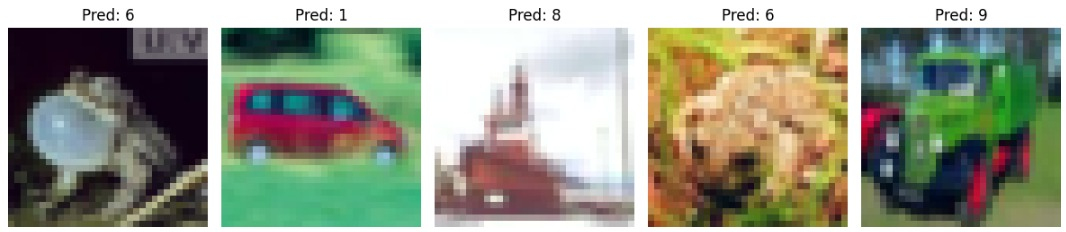

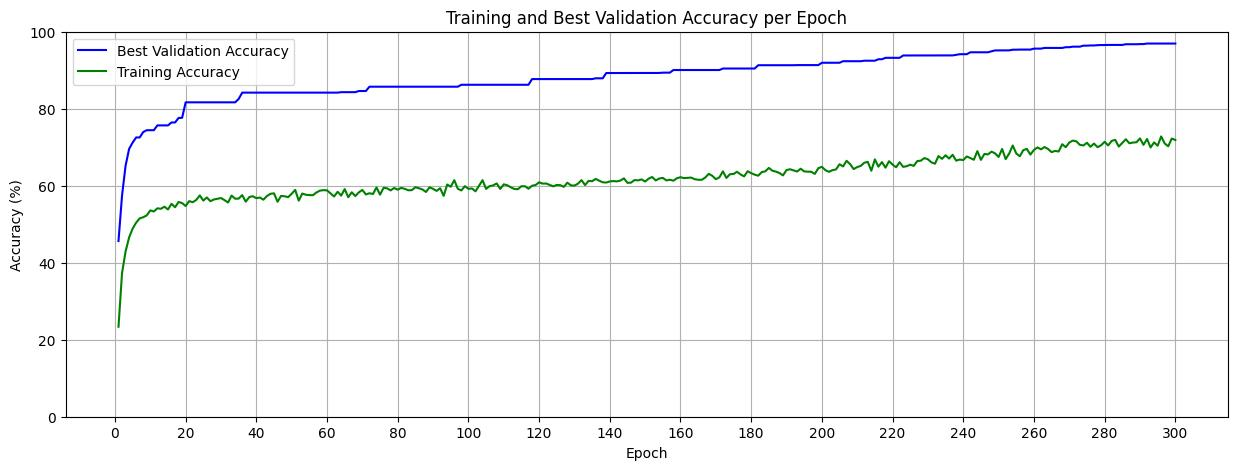